In [1]:
import pysam
import os
import sys
from sys import getsizeof
import time

directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, add_read_information_to_barcode_dict, get_hamming_distance


# An example on a bam for 875 cell barcodes (group0, group1, group2, group3, group4, group5, group6 split from the original bam)

### Should be about 875*30,000 = 26 million reads

#### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
bampath = '/projects/ps-yeolab3/ekofman/sailor2/data/groups_0_1_2_3_4_5_6_merged.bam'


In [35]:
samfile = pysam.AlignmentFile(bampath, "rb")



# Full test

In [213]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
#%load_ext memory_profiler


output_folder = '/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs'

MAX_NUM_READS = 1000000

# TOLERANCES/THRESHOLD FOR FILTERING
edit_type_of_interest = 'C>T'

dist_from_end_tolerance = 5
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 


contig_lengths_dict = get_contig_lengths_dict(samfile)

# THE HEAVY LIFTING
counts = defaultdict(lambda:defaultdict(lambda:0))
coverage_dict = {}
num_edits_per_read = {}
mapping_quality_per_read = {}

# Print info?
verbose = False 
    
EDITED_CODE = 'edited'
deletions = []

contigs = []


import time
start_time = time.perf_counter()


num_reads_to_coverage_dict_kb = {}
num_reads_to_seconds = {}



barcodes = defaultdict(lambda:defaultdict(lambda:[]))
bam_handles_for_barcodes = {}

total_reads = 0
for contig in contig_lengths_dict.keys():
    print(contig)
    try:
        contig_length = contig_lengths_dict.get(contig)
        reads_for_contig = samfile.fetch(contig, 0, contig_length)

        edit_info_subfolder = '{}/edit_info'.format(output_folder)
        if not os.path.exists(edit_info_subfolder):
            os.mkdir(edit_info_subfolder)
            
        output_file = '{}/{}_edit_info.tsv'.format(edit_info_subfolder, contig)
        if os.path.exists(output_file):
            print("{} exists... deleting".format(output_file))
            os.remove(output_file)
            
            
        with open(output_file, 'w') as f:        
            f.write('barcode\tcontig\tposition\tref\talt\tread_id\tstrand\tdist_from_end\tbase_quality\n')                       
            for i, read in enumerate(reads_for_contig):
                total_reads += 1
                if total_reads % 10000 == 0:
                    num_reads_to_coverage_dict_kb[total_reads] = getsizeof(coverage_dict)/1000
                    num_reads_to_seconds[total_reads] = time.perf_counter() - start_time
                    if total_reads % 100000 == 0:
                        print("\tTotal reads: {}".format(total_reads))
                        
                barcode = read.get_tag("CB")
                
                barcodes[contig][barcode].append(read)

                error_code, list_of_rows, num_edits_of_each_type = add_read_information_to_barcode_dict(read, contig, verbose=verbose)

                if error_code:
                    counts[contig][error_code] += 1
                else:
                    counts[contig][EDITED_CODE] += 1
                    for info_list in list_of_rows:
                        info_line = '\t'.join(info_list) + '\n'
                        f.write(info_line)
                        
                # WRITE READ TO BAM FILE SPECIFIC TO THAT BARCODE AND THAT CONTIG
                barcode_bam_file_path = "{}/split_bams/contig_{}/{}.bam".format(output_folder, contig, barcode)
                bam_for_barcode = bam_handles_for_barcodes.get(barcode_bam_file_path)
                if not bam_for_barcode:
                    bam_for_barcode = pysam.AlignmentFile(barcode_bam_file_path, "wb", template=samfile)
                    bam_handles_for_barcodes[barcode_bam_file_path] = bam_for_barcode
                bam_for_barcode.write(read)
                
                # BREAK OUT EARLY ONCE WE HIT NUMBER OF READS
                if counts[contig][error_code] + counts[contig][EDITED_CODE]> MAX_NUM_READS:
                    print("We maxed out past {}".format(MAX_NUM_READS))
                    break
                
        
        contigs.append(contig)
        
        
        

    except Exception as e:
        print(contig, e)
        
    # Index all subset bams
    for barcode_bam_file_path, bam_file_handle in bam_handles_for_barcodes.items():
        bam_file_handle.close()
        if not os.path.exists('{}.bai'.format(barcode_bam_file_path)):
            pysam.index(barcode_bam_file_path)

    if contig == '15':
        break
    

1
/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/edit_info/1_edit_info.tsv exists... deleting
	Total reads: 100000
	Total reads: 200000
	Total reads: 300000
10
/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/edit_info/10_edit_info.tsv exists... deleting
	Total reads: 400000
	Total reads: 500000
	Total reads: 600000
11
/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/edit_info/11_edit_info.tsv exists... deleting
	Total reads: 700000
	Total reads: 800000
	Total reads: 900000
	Total reads: 1000000
	Total reads: 1100000
12
/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/edit_info/12_edit_info.tsv exists... deleting
	Total reads: 1200000
	Total reads: 1300000
13
/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_outs/edit_info/13_edit_info.tsv exists... deleting
	Total reads: 1400000
	Total reads: 1500000
14
/projects/ps-yeolab3/ekofman

# Time profiling 

#### Identifying edits, as well as splitting reads by barcode into separate bams, is O(reads) in terms of time

Text(0.5, 1.0, 'Time vs. number of reads')

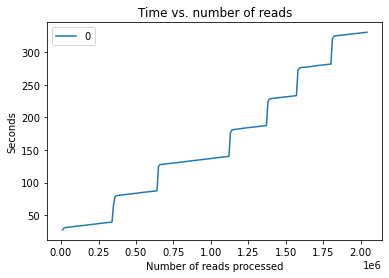

In [214]:

pd.DataFrame.from_dict(num_reads_to_seconds, orient='index').plot()
plt.ylabel("Seconds")
plt.xlabel("Number of reads processed")
plt.title("Time vs. number of reads")

In [216]:
rates = []
for reads, secs in zip(list(num_reads_to_seconds.keys()), list(num_reads_to_seconds.values())):
    rate = reads/secs
    rates.append(rate)

Average of 6061.198556516674 reads/second


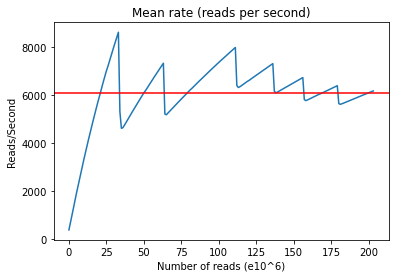

In [224]:
plt.plot(range(len(rates)), rates)
plt.title("Mean rate (reads per second)")
plt.ylabel("Reads/Second")
plt.xlabel("Number of reads (e10^6)")

average_rate = np.mean(rates)
plt.axhline(average_rate, color='r')
print("Average of {} reads/second".format(average_rate))

In [227]:
seconds_per_read = 1/average_rate

In [247]:
reads_per_cell = 40000
total_cells = 20000
total_reads = reads_per_cell * total_cells
print(total_reads)

total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} reads: {} minutes'.format(total_reads, round(total_estimated_time/60), 3))
print('Estimated total time in hours for {} reads: {} hours'.format(total_reads, round(total_estimated_time/3600), 3))
print("This can be split across contigs, to probably reduce to max 2-3 hours total with multiprocessing")

800000000
Estimated total time in minutes for 800000000 reads: 2200 minutes
Estimated total time in hours for 800000000 reads: 37 hours
This can be split across contigs, to probably reduce to max 2-3 hours total with multiprocessing


# Write reads for each barcode for each contig into separate bams

# Second loop to get coverage at sites with edits

In [244]:
all_edit_info_for_barcodes = []

for contig in contig_lengths_dict.keys():
    print(contig)
    reads_skipped = 0
    
    barcode_to_coverage_dict = defaultdict()
    
    
    contig_length = contig_lengths_dict.get(contig)
    
    barcode_to_coverage_dict = defaultdict()
    output_file = '{}/edit_info/{}_edit_info.tsv'.format(output_folder, contig)
    edit_info = pd.read_csv(output_file, sep='\t')
    
    unique_barcodes = sorted(edit_info.barcode.unique())
    

    for i, barcode in enumerate(unique_barcodes):
        if i % 100 == 0:
            print('{}/{}'.format(i, len(unique_barcodes)))
    
        barcode_bam = '{}/split_bams/contig_{}/{}.bam'.format(output_folder, contig, barcode)
    
        try:
            samfile_for_barcode = pysam.AlignmentFile(barcode_bam, "rb")

            edit_info_for_barcode = edit_info[edit_info.barcode == barcode]
            positions_for_barcode = edit_info_for_barcode.position.tolist()

            coverage = []
            for pos in positions_for_barcode:
                coverage_at_pos = np.sum(samfile_for_barcode.count_coverage(contig, pos-1, pos))
                coverage.append(coverage_at_pos)

            edit_info_for_barcode['coverage'] = coverage
            all_edit_info_for_barcodes.append(edit_info_for_barcode)
        except Exception as e:
            print(e)


    


1
0/875


/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
10
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
11
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
12
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
13
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
14
0/874
100/874
200/874
300/874
400/874
500/874
600/874
700/874
800/874
15
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
16
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
17
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
18
0/869
100/869
200/869
300/869
400/869
500/869
600/869
700/869
800/869
19
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
2
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/875
800/875
3
0/874
100/874
200/874
300/874
400/874
500/874
600/874
700/874
800/874
4
0/875
100/875
200/875
300/875
400/875
500/875
600/875
700/87

In [249]:
all_edit_info = pd.concat(all_edit_info_for_barcodes)

In [250]:
all_edit_info['contig'] = all_edit_info.contig.astype(str)

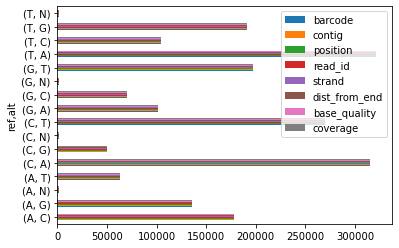

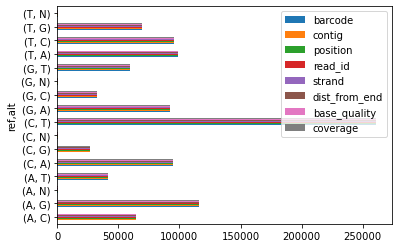

In [253]:
all_edit_info.groupby(['ref', 'alt']).count().plot(kind='barh')

all_edit_info[all_edit_info.base_quality > 15].groupby(['ref', 'alt']).count().plot(kind='barh')


all_edit_info_filtered = all_edit_info[all_edit_info.base_quality > 15]

In [254]:
example_new_ct =  all_edit_info_filtered[(all_edit_info_filtered.ref == 'C') & (all_edit_info_filtered.alt == 'T')].sort_values('position')

In [255]:
len(example_new_ct)

261270

In [256]:
example_new_ct

,barcode,contig,position,ref,alt,read_id,strand,dist_from_end,base_quality,coverage
61,AACAACCAGTAATACG-1,MT,2767,C,T,A01535:287:H3JJHDSX7:2:1273:15157:16094,+,17,37,8
8,AAACCCACACCGTGGT-1,MT,2794,C,T,A01535:287:H3JJHDSX7:1:2352:3640:34287,+,27,37,10
74,AACAAGACATTCGATG-1,MT,2802,C,T,A01535:287:H3JJHDSX7:1:2268:5791:28808,+,19,37,3
127,AAACGAACAGAACTTC-1,MT,2904,C,T,A01535:287:H3JJHDSX7:2:2424:26250:24502,+,8,37,1
148,AAAGTCCAGTCGGCCT-1,MT,2927,C,T,A01535:287:H3JJHDSX7:1:1151:26449:4492,+,49,37,1
...,...,...,...,...,...,...,...,...,...,...
94213,AAACCCACAAAGACGC-1,1,194961071,C,T,A01535:287:H3JJHDSX7:1:2106:16486:14356,+,3,37,5
94217,AACACACGTTTGTTCT-1,1,194961117,C,T,A01535:287:H3JJHDSX7:1:1278:24008:19742,+,28,37,1
94272,AAAGGATCATGAAGCG-1,1,195036921,C,T,A01535:287:H3JJHDSX7:1:2307:26910:7639,-,30,37,1
94279,AAAGGGCCACCAGTTA-1,1,195047095,C,T,A01535:287:H3JJHDSX7:1:2602:27670:19820,-,39,37,1


# Cells that do have STAMP expressed versus don't...?

In [258]:
stamp_expression_path = \
'/projects/ps-yeolab3/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_combined/\
4.1_cells_with_middling_stamp/stamp_expression_for_all_used_cells.tsv'

In [262]:
stamp_expression_df = pd.read_csv(stamp_expression_path, sep='\t', index_col=0)

<AxesSubplot:>

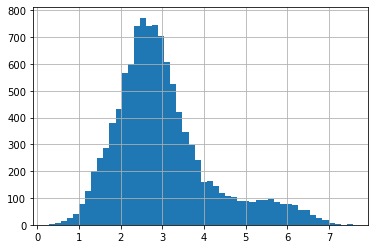

In [266]:
stamp_expression_df.Stamp.hist(bins=50)

0
1
2
3
4
5
6


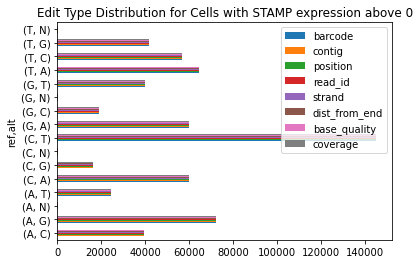

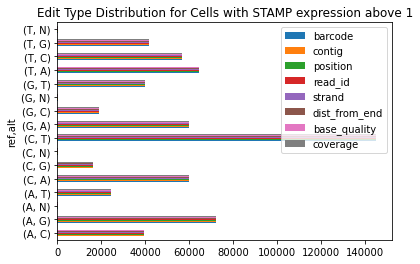

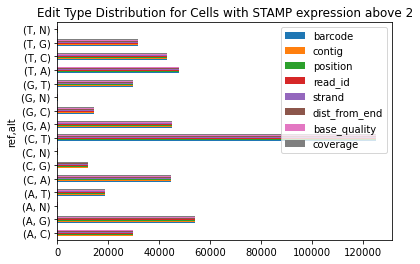

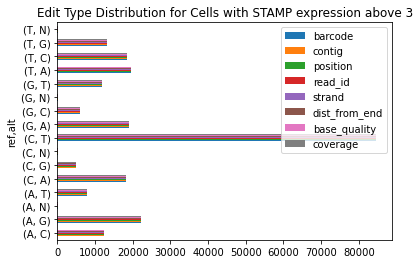

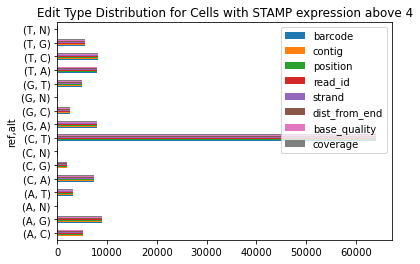

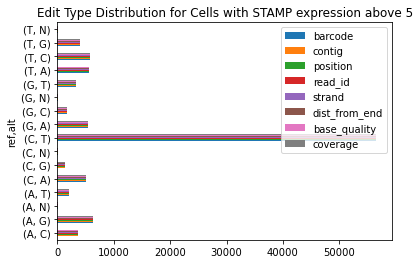

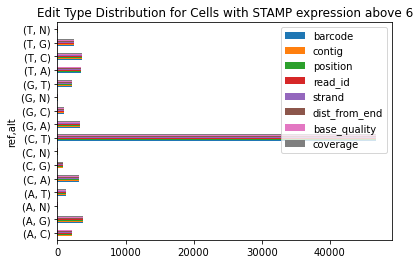

In [303]:
for thresh in [0, 1, 2, 3, 4, 5, 6]:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp > thresh].index
    
    all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)].groupby(['ref', 'alt']).count().plot(kind='barh')
    plt.title("Edit Type Distribution for Cells with STAMP expression above {}".format(thresh))

# Extract only reads for a barcode

In [298]:
# Get edits for barcode
barcode = 'AAACCCAAGATTGCGG'


example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])


In [299]:

comparison_vals = []
overlapping_by_contig = {}
old_for_contig = {}
new_for_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    old_for_contig[contig] = example_old_ct_for_contig
    new_for_contig[contig] = example_new_ct_for_contig
    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 11
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 31
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 19
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 11
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 18


# Which sites are we recovering?

In [300]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

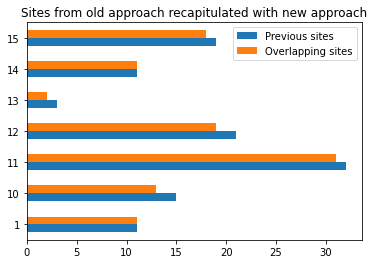

In [301]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].head(22).plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [302]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: 1.0
10
	Correlation between old coverage and new coverage values: 1.0
11
	Correlation between old coverage and new coverage values: 1.0
12
	Correlation between old coverage and new coverage values: 1.0
13
	Correlation between old coverage and new coverage values: 1.0
14
	Correlation between old coverage and new coverage values: 1.0
15
	Correlation between old coverage and new coverage values: 1.0
